# Pourquoi la convolution ?

Un des pré-requis à l'entraînement de réseaux de neurones dédiés au traitement de l'image est aujourd'hui la **convolution**.

Les réseaux de neurones convolutifs, les _CNN_, occupent aujourd'hui en santé une place majeure : classification, segmentation, survie, marqueurs pronostics, etc.

**Pourquoi utilise-t-on aujourd'hui _presque_ exclusivement ce type d'opération mathématique pour analyser nos images ?**

Réponse courte : les _CNN_ peuvent extraire automatiquement des informations morphologiques qui échappent à un oeil expert, pour un coup computationnel bien plus faible que les architectures classiques comme les _perceptrons_. Ces réseaux permettent de mieux capturer la complexité inhérente aux images qu'ils analysent.

## Implémentation d'un perceptron multi-couches

On importe quelques packages utiles pour la suite.

In [1]:
from typing import Tuple

import tensorflow as tf
import tensorflow_datasets as tfds

%matplotlib inline

Puis on réalise un point de montage avec le contenu de notre drive.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


On charge le data set MNIST.

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    data_dir='/content/gdrive/MyDrive/data/',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

On affiche les chiffres à classifier.

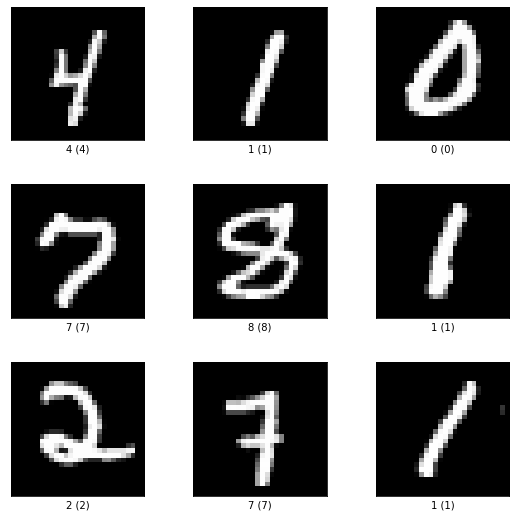

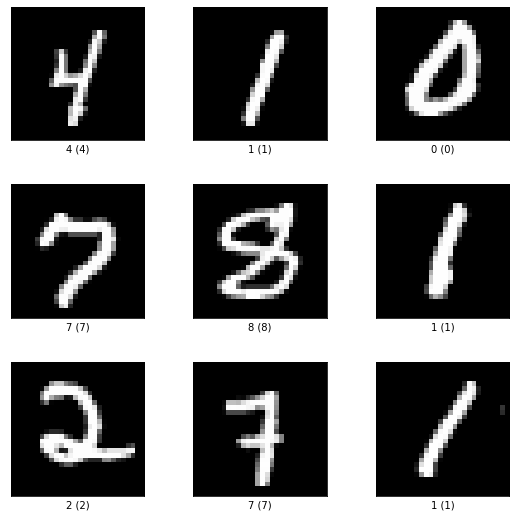

In [4]:
tfds.visualization.show_examples(ds_train, ds_info)

Puis les informations d'intérêt sur ce data set.

In [5]:
print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/content/gdrive/MyDrive/data/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


Comme précédemment, on convertit en format _floattant_. Pas besoin de normaliser car les images sont en noir et blanc !

In [6]:
def normalize_img(image: tf.Tensor, label: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    """Conversion et normalisation."""
    img = tf.cast(image, tf.float32) / 255.
    return img, label

In [7]:
# on applique les transformations de manière parallélisée.
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE
)

# on cache de manière à faire la transformation précédente une seule fois
# au début de l'entraînement.
ds_train = ds_train.cache()

# on permute aléatoirement les exemples.
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)

# on constitue des batches de taille 128.
ds_train = ds_train.batch(128)

# enfin, on demande à Tensorflow de traiter la donnée
# même si le GPU est en train de calculer (système de queue).
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

De la même manière, on construit l'échantillon de test.

In [8]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
ds_test

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Enfin, on implémente un MLP à 1 couche cachée de taille : 784 (entrée), 128 (cachée) et 10 (sortie).
Pour cela, on aplatit les images en un seul et même vecteur de taille $28\times 28=784$.

In [12]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # entrée
  tf.keras.layers.Dense(128, activation='relu'), # couche cachée
  tf.keras.layers.Dense(10, activation='softmax') # couche de sortie
])
# on définit un optimiseur pour l'entraînement.
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
# on entraîne sur 20 epochs.
model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_test,
)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


469/469 [==============================] - 12s 9ms/step - loss: 0.3507 - sparse_categorical_accuracy: 0.9038 - val_loss: 0.1880 - val_sparse_categorical_accuracy: 0.9473
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1631 - sparse_categorical_accuracy: 0.9539 - val_loss: 0.1362 - val_sparse_categorical_accuracy: 0.9595
Epoch 3/20
469/469 [==============================] - 2s 3ms/step - loss: 0.1165 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.1205 - val_sparse_categorical_accuracy: 0.9656
Epoch 4/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0920 - sparse_categorical_accuracy: 0.9736 - val_loss: 0.1012 - val_sparse_categorical_accuracy: 0.9701
Epoch 5/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0737 - sparse_categorical_accuracy: 0.9787 - val_loss: 0.0881 - val_sparse_categorical_accuracy: 0.9740
Epoch 6/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0603 - sparse_categorical_accuracy

**Nombre de paramètres requis pour l'entraînement.**

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


## Comparaison avec un petit réseau convolutif

**Faisons la même chose mais entraînons un réseau convolutif...**

In [14]:
model = tf.keras.models.Sequential([
    # première couche de convolutions en 2D.
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
    # premier pooling.
    tf.keras.layers.MaxPooling2D((2, 2)),
    # deuxième couche de convolutions en 2D.
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # troisième couche de convolutions en 2D.
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # quatrième couche de convolutions en 2D.
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
    # on transforme la sortie en un vecteur 1D.
    tf.keras.layers.Flatten(),
    # et on applique un softmax.
    tf.keras.layers.Dense(10, activation='softmax')
])
# on définit un optimiseur pour l'entraînement.
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
# on entraîne sur 20 epochs.
model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_test,
)

Epoch 1/20
469/469 [==============================] - 11s 6ms/step - loss: 0.5196 - sparse_categorical_accuracy: 0.8463 - val_loss: 0.1673 - val_sparse_categorical_accuracy: 0.9496
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 0.1423 - sparse_categorical_accuracy: 0.9559 - val_loss: 0.1063 - val_sparse_categorical_accuracy: 0.9664
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.9676 - val_loss: 0.0870 - val_sparse_categorical_accuracy: 0.9733
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0852 - sparse_categorical_accuracy: 0.9734 - val_loss: 0.0779 - val_sparse_categorical_accuracy: 0.9754
Epoch 5/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0745 - sparse_categorical_accuracy: 0.9774 - val_loss: 0.0689 - val_sparse_categorical_accuracy: 0.9783
Epoch 6/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0652 - sparse_categoric

**Nombre de paramètres requis pour l'entraînement.**

In [15]:
model.summary() # 12 874 contre 101 770 précédemment...

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 32)          4128      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 32)        

Ici semble se dessiner un premier indice de pourquoi plus personne n'utilise de MLP pour analyser les images, mais plutôt des réseaux convolutifs : **le nombre de paramètres est plus faible** tandis que **la convolution semble également mieux capturer l'information importante pour classer les images**.

## Convolution : motivations

Bien qu'efficaces pour le traitement d'images, les perceptrons multicouches (MLP) ont des difficultés à gérer des images de grande taille, en raison de la croissance exponentielle du nombre de connexions avec la taille de l'image, du fait que chaque neurone est « totalement connecté » à chacun des neurones de la couche précédente et suivante.

### Visualisation de certains noyaux de convolution de référence pour fixer la notion

https://setosa.io/ev/image-kernels/

#### Méthodes implémentées sur `scikit-image`.

In [16]:
from skimage import filters
from skimage import data
import matplotlib.pyplot as plt

In [17]:
print(f"Transformations : {[d for d in dir(filters) if not d.startswith('_')]}")

Transformations : ['LPIFilter2D', 'apply_hysteresis_threshold', 'correlate_sparse', 'difference_of_gaussians', 'edges', 'farid', 'farid_h', 'farid_v', 'frangi', 'gabor', 'gabor_kernel', 'gaussian', 'hessian', 'inverse', 'laplace', 'lpi_filter', 'median', 'meijering', 'prewitt', 'prewitt_h', 'prewitt_v', 'rank', 'rank_order', 'ridges', 'roberts', 'roberts_neg_diag', 'roberts_pos_diag', 'sato', 'scharr', 'scharr_h', 'scharr_v', 'sobel', 'sobel_h', 'sobel_v', 'threshold_isodata', 'threshold_li', 'threshold_local', 'threshold_mean', 'threshold_minimum', 'threshold_multiotsu', 'threshold_niblack', 'threshold_otsu', 'threshold_sauvola', 'threshold_triangle', 'threshold_yen', 'thresholding', 'try_all_threshold', 'unsharp_mask', 'wiener', 'window']


In [18]:
camera = data.camera() # noir et blanc
coffee = data.coffee() # rvb

#### Visualisation de certaines transformations

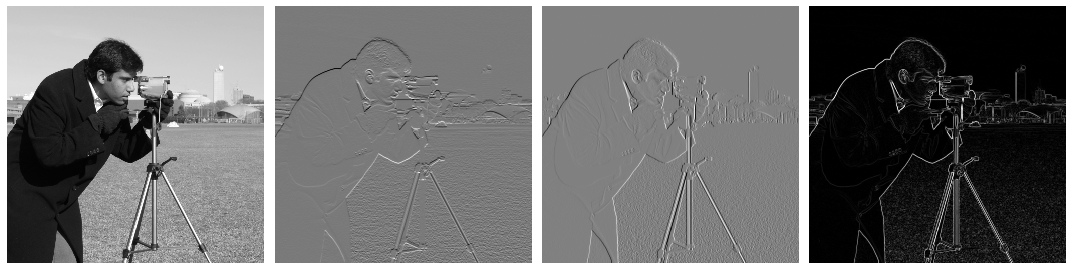

In [19]:
plt.figure(figsize=(15, 5))
plt.subplot(141)
plt.imshow(camera, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(142)
plt.imshow(filters.sobel_h(camera), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(143)
plt.imshow(filters.sobel_v(camera), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(144)
plt.imshow(filters.sobel(camera), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.tight_layout()
plt.show()

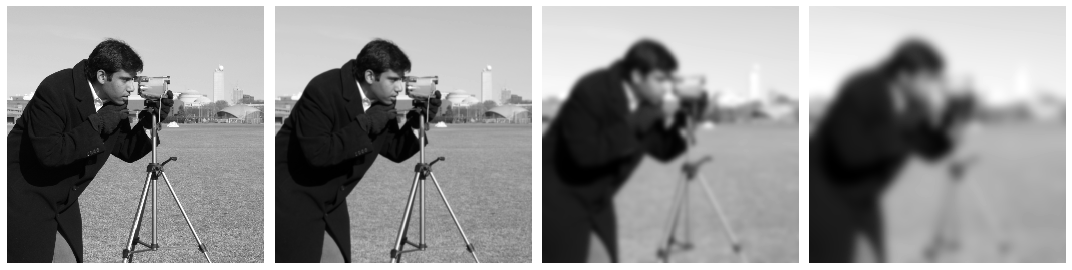

In [20]:
plt.figure(figsize=(15, 5))
plt.subplot(141)
plt.imshow(camera, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(142)
plt.imshow(filters.gaussian(camera, sigma=1), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(143)
plt.imshow(filters.gaussian(camera, sigma=5), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(144)
plt.imshow(filters.gaussian(camera, sigma=10), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.tight_layout()
plt.show()

Comme on l'a vu sur le site précédent, un noyau de convolution va **faire ressortir certaines caractéristiques saillantes de l'image d'entrée**. 

**Pour analyser plusieurs caractéristiques, on va empiler des strates de noyaux de convolution indépendants, chaque strate analysant une caractéristique de l'image.**

**L'ensemble des strates ainsi empilées forme la « couche de traitement convolutif »** ou **convolutional layer**, qu'il faut voir en fait comme un volume (souvent appelé « volume de sortie »). Le nombre de strates de traitement (ou **filters**) s'appelle la profondeur de la couche de convolution (à ne pas confondre avec la profondeur d'un réseau de neurones convolutifs qui compte le nombre de couches de convolution).


<img src="https://miro.medium.com/max/1992/0*U5Ej4yTMTQBfyr_N.png" width="400">





<img src="https://miro.medium.com/max/1898/0*R52u4buyPfabCeyV.png" width="400">




<img src="https://images4.programmersought.com/795/e2/e2809fb699bfbab4ea40ff1fea956813.png" width="400">




Pour résumé, l'essentiel d'un _CNN_ est assuré par les neurones de traitement, qui traitent une portion limitée de l'image (appelée « **champ réceptif** ») au travers d'une fonction de **convolution**. **Les réseaux de neurones convolutifs visent à limiter le nombre d'entrées tout en conservant la forte corrélation « spatialement locale » des images naturelles.**

Les 3 grands avantages de la convolution sont les suivants :

- **Connectivité locale** : grâce au champ récepteur qui limite le nombre d'entrées du neurone (par exemple $3\times 3$), les réseaux de neurones convolutifs assurent ainsi que les filtres produisent **la réponse la plus forte à un motif d'entrée spatialement localisé, ce qui conduit à une représentation parcimonieuse de l'entrée. De plus, le nombre de paramètres à estimer étant réduit, leur estimation (statistique) est plus robuste pour un volume de données fixé (comparé à un MLP).** Au travers du processus d'optimisation, chaque filtre va se spécialiser dans une caractéristique spéciale de l'image; caractéristique qui s'avère pertinente pour la prédiction finale.

- **Poids partagés** : dans les réseaux de neurones convolutifs, les paramètres de filtrage d'un neurone (pour un champ récepteur donné) sont identiques pour tous les autres neurones d'un même noyau (traitant tous les autres champs récepteurs de l'image), ce qui ccupe moins d'espace en mémoire. 

- **Invariance à la translation** : comme tous les neurones d'un même noyau (filtre) sont identiques, le motif détecté par ce noyau est indépendant de localisation spatiale dans l'image.
    

### Profondeur, stride et padding

Trois hyperparamètres permettent de dimensionner le volume de la couche de convolution (aussi appelé volume de sortie) : la profondeur (**depth**), le pas (**stride**) et la marge (**pad**).

- **Depth** : nombre de noyaux de convolution (ou nombre de neurones associés à un même champ récepteur).
- **Stride** : contrôle le chevauchement des champs récepteurs. Plus le pas est petit, plus les champs récepteurs se chevauchent et plus le volume de sortie sera grand.
- **Pad** : La marge (à 0) ou zero padding : parfois, il est commode de mettre des zéros à la frontière du volume d'entrée. Cette marge permet de contrôler la dimension spatiale du volume de sortie. En particulier, il est parfois souhaitable de conserver la même surface que celle du volume d'entrée.

Illustration d'un _stride_=2 :

<img src="https://miro.medium.com/max/395/1*1VJDP6qDY9-ExTuQVEOlVg.gif" width="200">

Illustration du _padding_ : 

<img src="https://miro.medium.com/max/395/1*nYf_cUIHFEWU1JXGwnz-Ig.gif" width="200">

### Pooling

Un autre concept important des CNNs est le **pooling**, ce qui est une forme de sous-échantillonnage (ou _downsampling_) de l'image. Le pooling réduit la taille spatiale d'une image intermédiaire, réduisant ainsi la quantité de paramètres et de calcul dans le réseau. **Il est donc fréquent d'insérer périodiquement une couche de pooling entre deux couches convolutives successives d'une architecture de réseau de neurones convolutifs pour réduire le sur-apprentissage.**

**Très important : l'opération de pooling crée aussi une forme d'invariance par translation et rotation.** En effet, celui-ci permet de garder les features les plus saillantes sur l'image (ou ses représentations intermédiaires), peu importe la localisation initiale de celle-ci. 

La forme la plus courante est une couche de _pooling_ de taille 2 × 2 (largeur/hauteur) et comme valeur de sortie la valeur maximale en entrée (_max-pooling_). On parle dans ce cas de « Max-Pool 2x2 » (compression d'un facteur 4). Il est aussi possible d'éviter la couche de pooling30 mais cela implique un risque de sur-apprentissage plus important. 


<img src="https://miro.medium.com/max/2400/1*KQIEqhxzICU7thjaQBfPBQ.png" width="400">

### Couche d'activation non-linéaire

La convolution est une opération purement linéaire (produit de matrice). De fait, sans activation non-linéaire, il serait bien difficile de modéliser des relations non-linéaires et donc relativement complexes, entre les images d'entrée et la sortie (_i.e._ la prédiction). 

Ces dernières années c'est imposé l'activation dite ReLU pour **Rectified Linear Unit** (2010, Nair, Vinod and Hinton, Geoffrey E.  Rectified linearunits  improve  restricted  Boltzmann  machines. Cette fonction d'activation présente l'immense intérêt d'agir à la fois comme un moyen efficace de **propager les gradients** (on parle de **vanishing gradient problem**) car la gradient de cette fonction ne sature pas (c'est la fonction idendité); mais également comme un bon régulariseur car, comme la fonction de Heaviside, les neurones ne s'activent que lorsque la somme pondérée qui leur est transmise est positive.


<img src="https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-07-at-6-18-19-pm.png?w=748" width="600">

### Couches denses

Très généralement, on utilise les différentes couches précédemment citées dans l'ordre suivant : convolution, activation, pooling.
Au fur et à mesure que l'image initiale est traitée, la dimension de sa représentation diminue en longueur et largeur, jusqu'à atteindre une taille $h_f \times w_f \times d_f$. Dans l'exemple que nous avions pris plus haut, l'ensemble des différentes convolutions et opérations de _pooling_ avait mené à une représentation de l'image de taille $1 \times 1 \times 32$, c'est-à-dire $32$ valeurs. 

Dans le cadre ici d'une **classification**, l'avant dernière étape consiste à utiliser des couches entièrement connectées, c'est-à-dire un perceptron, avec plus ou moins de couches ! **Les neurones dans une couche entièrement connectée ont des connexions vers toutes les sorties de la couche précédente (comme on le voit régulièrement dans les réseaux réguliers de neurones)**. Le premier réseau de neurones convolutif profond AlexNet (Lecun, 1988) entraîné selon la méthode de _backpropagation_ (dans le cadre de la classification MNIST); **plus de 90 % des paramètres à apprendre sont dus aux 3 couches « complètement connectées » les plus profondes, et le reste concerne les (5) couches convolutives.**

<img src="https://learnopencv.com/wp-content/uploads/2018/05/AlexNet-1.png" width="800">

<img src="https://miro.medium.com/max/3684/1*vXBvV_Unz3JAxytc5iSeoQ.png" width="800">

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 32)          4128      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 32)        

### Couche softmax

La couche de perte spécifie comment l'entrainement du réseau pénalise l'écart entre la prédiction et le label réel attendu. Elle est normalement la dernière couche dans le réseau. Diverses fonctions de perte adaptées à différentes tâches peuvent y être utilisées.

La perte **softmax** est utilisée pour prédire une seule classe parmi *K* classes mutuellement exclusives. 


<img src="https://deepnotes.io/public/images/softmax.png" width="400">

<img src="https://miro.medium.com/max/1906/1*ReYpdIZ3ZSAPb2W8cJpkBg.jpeg" width="400">


### Fonction de coût

La perte par entropie croisée sigmoide est utilisée pour prédire $K$ valeurs de probabilité indépendante dans [ 0 , 1 ] {\displaystyle [0,1]} {\displaystyle [0,1]}. La perte euclidienne est utilisée pour régresser vers des valeurs réelles dans $[-\infty ,\infty ]$. 

<img src="https://miro.medium.com/max/919/1*ETtY7KCrzAlOmLeyDWE4Xg.png" width="400">

In [22]:
import numpy as np

# y_true = [0, 1, 2]
y_true = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])
y_pred = np.array([
    [0.2, 0.5, 0.3],
    [0.1, 0.8, 0.1],
    [0.4, 0.3, 0.3]
])
# Implémentation TensorFlow.
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
print(f'Résultat Tensorflow : {cce(y_true, y_pred).numpy()}')
ours = -np.diag((y_true * np.log(y_pred))).mean()
print(f'Résultat ad-hoc: {ours}')

Résultat Tensorflow : 1.0121847560247488
Résultat ad-hoc: 1.0121847560247488


Si l'on refait l'exercice avec les mêmes classes prédites mais des probabilités plus éclatées pour les cas où il y a des erreurs.

In [23]:
import numpy as np

# y_true = [0, 1, 2]
y_true = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])
y_pred = np.array([
    [0.04, 0.95, 0.01], # erreur
    [0.1, 0.8, 0.1],
    [0.9, 0.1, 0.1] # erreur
])
# Implémentation TensorFlow.
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
print(f'Résultat Tensorflow : {cce(y_true, y_pred).numpy()}')
ours = -np.diag((y_true * np.log(y_pred))).mean()
print(f'Résultat ad-hoc: {ours}')
# L'erreur est plus élevée : quand on se trompe, on se trompe "trop".

Résultat Tensorflow : 1.946638216326927
Résultat ad-hoc: 1.9148681563921521


## Backpropagation et convolution

Quelques illustrations empruntées de ce blog : https://medium.com/@pavisj/convolutions-and-backpropagations-46026a8f5d2c.


    
<img src="https://miro.medium.com/max/692/1*VNr0GiFEwjmwj2v9YmPn5Q.png" width="600">

<img src="https://miro.medium.com/max/700/1*Q2GGz43E-o5FEtaDXuw8tA.png" width="600">

<img src="https://miro.medium.com/max/700/1*K7dINARev0NUB-HWp9mbwA.gif" width="600">

<img src="https://miro.medium.com/max/700/1*w8VkZ50foXWTmoXDDnr8tg.png" width="600">

<img src="https://miro.medium.com/max/650/1*N2qQtWd5MbUbP8ND-2mR_A.gif" width="600">

<img src="https://miro.medium.com/max/692/1*VNr0GiFEwjmwj2v9YmPn5Q.png" width="600">

<img src="https://miro.medium.com/max/692/1*VNr0GiFEwjmwj2v9YmPn5Q.png" width="600">



### Visualisation

- CNN : https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html
- MLP : https://www.cs.ryerson.ca/~aharley/vis/fc/
    

### Sources supplémentaires

- https://www.math.univ-toulouse.fr/~besse/Wikistat/pdf/st-m-hdstat-rnn-deep-learning.pdf
- https://stanford.edu/~shervine/l/fr/teaching/cs-230/pense-bete-reseaux-neurones-convolutionnels

Ressources plus générales en deep learning :
- https://stanford.edu/~shervine/l/fr/teaching/cs-230/pense-bete-petites-astuces-apprentissage-profond

### En plus

- _Batch normalisation_ : https://en.wikipedia.org/wiki/Batch_normalization
- _Stochastic Gradient Descent_ : https://en.wikipedia.org/wiki/Stochastic_gradient_descent
- _Weight initialization_ : https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79